1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

In [8]:
import scipy
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.colors import LogNorm

[[-2.         -1.98997494 -1.97994987 ...  1.97994987  1.98997494
   2.        ]
 [-2.         -1.98997494 -1.97994987 ...  1.97994987  1.98997494
   2.        ]
 [-2.         -1.98997494 -1.97994987 ...  1.97994987  1.98997494
   2.        ]
 ...
 [-2.         -1.98997494 -1.97994987 ...  1.97994987  1.98997494
   2.        ]
 [-2.         -1.98997494 -1.97994987 ...  1.97994987  1.98997494
   2.        ]
 [-2.         -1.98997494 -1.97994987 ...  1.97994987  1.98997494
   2.        ]] [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.98994975 -0.98994975 -0.98994975 ... -0.98994975 -0.98994975
  -0.98994975]
 [-0.9798995  -0.9798995  -0.9798995  ... -0.9798995  -0.9798995
  -0.9798995 ]
 ...
 [ 0.9798995   0.9798995   0.9798995  ...  0.9798995   0.9798995
   0.9798995 ]
 [ 0.98994975  0.98994975  0.98994975 ...  0.98994975  0.98994975
   0.98994975]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]


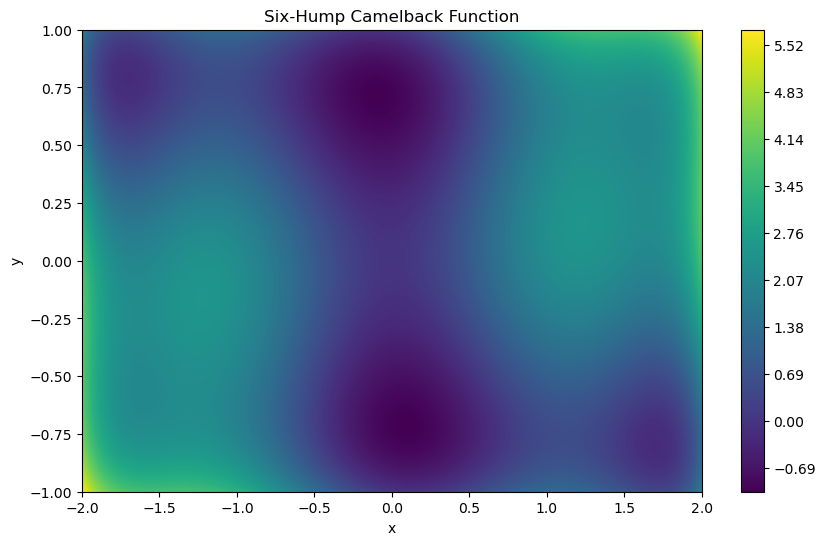

Local minima
0.0 0.0
1e-08 0.0
0.0 1e-08
Initial Guess: [0, 0]
Optimal Solution: [0. 0.]
Minimum Value of the Function: 0.0

1.0 -1.0
1.00000001 -1.0
1.0 -0.99999999
0.4000000355271365 1.0
0.40000004552713647 1.0
0.4000000355271365 0.99999999
0.7023862349911694 -0.007954057896311761
0.7023862449911694 -0.007954057896311761
0.7023862349911694 -0.007954047896311761
0.4893727227664736 0.7020910248957883
0.4893727327664736 0.7020910248957883
0.4893727227664736 0.7020910348957884
-0.42314763000080824 1.0
-0.42314762000080824 1.0
-0.42314763000080824 0.99999999
0.02989780796865618 0.8520950226569445
0.029897817968656183 0.8520950226569445
0.02989780796865618 0.8520950326569445
-0.5091484325728208 0.34662740054758256
-0.5091484225728208 0.34662740054758256
-0.5091484325728208 0.34662741054758256
-0.1100073956709489 0.7209048848064313
-0.1100073856709489 0.7209048848064313
-0.1100073956709489 0.7209048948064314
-0.08597911626187853 0.7127404470537804
-0.08597910626187853 0.7127404470537804
-0.

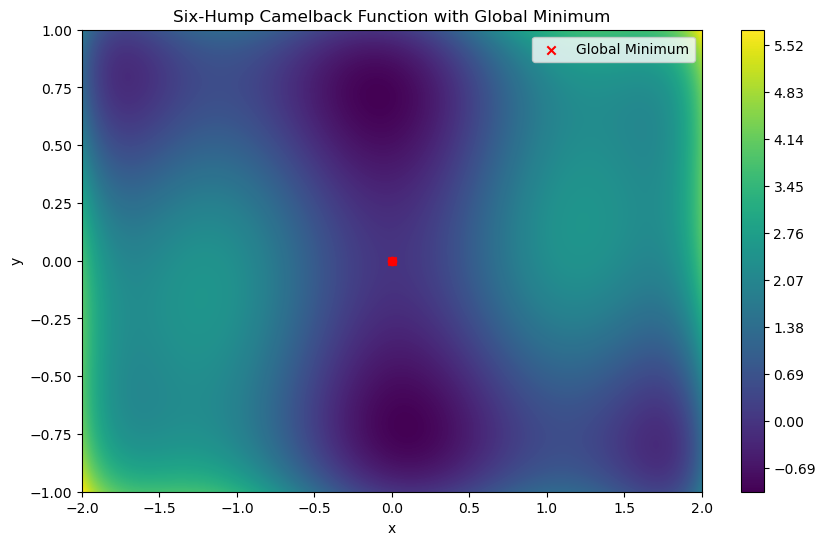

In [2]:

def f(x):
    x,y = x
    print(x,y)
    return (4-2.1*(x**2) + (x**4)/3)*(x**2)+ x*y + (4* (y**2) -4)* (y**2)

x_range = np.linspace(-2, 2, 400)
y_range = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x_range, y_range)
Z = f([X, Y])

# Visualize the function surface
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=500, cmap='viridis')
plt.colorbar()
plt.title('Six-Hump Camelback Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#local minimas
# Try different initial guesses
print('Local minima')
initial_guesses = [[0, 0], [1, -1], [-1, -1], [1, 1], [-1, 1]]
bounds = [(-2, 2), (-1, 1)]
# Find global minima using scipy.optimize.minimize for each initial guess
for guess in initial_guesses:
    result = minimize(f, guess, bounds=bounds)
    print(f"Initial Guess: {guess}")
    print(f"Optimal Solution: {result.x}")
    print(f"Minimum Value of the Function: {result.fun}")
    print()

    

# Find global minima using scipy.optimize.minimize

initial_guess = [0, 0]
bounds = [(-2, 2), (-1, 1)]

result = minimize(f, initial_guess, bounds=bounds)

# Display the result
print("Global Minima:")
print(f"Number of Iterations: {result.nit}")
print(f"Optimal Solution: {result.x}")
print(f"Minimum Value of the Function: {result.fun}")

# Plot the convergence
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=500, cmap='viridis')
plt.colorbar()
plt.scatter(result.x[0], result.x[1], color='red', marker='x', label='Global Minimum')
plt.plot(result.x[0], result.x[1], 'ro')  # Mark the final point
plt.title('Six-Hump Camelback Function with Global Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

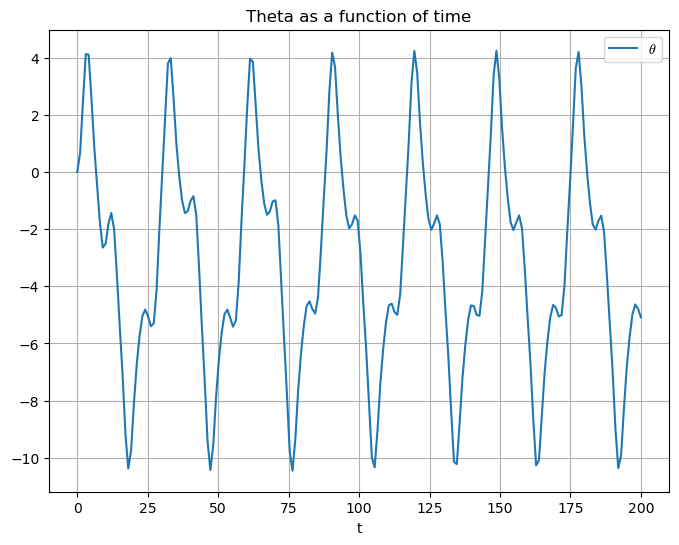

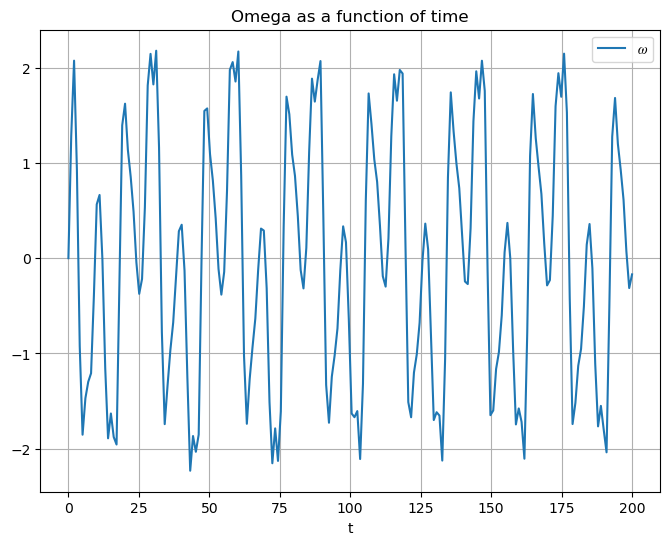

In [6]:
from scipy.integrate import odeint
import math

init = (0,0)
Q = 2
d = 1.5
l = 10
g = 9.8
omega = 0.65
t = np.linspace(0,200,200)


def f (x,t,omega,d,g,Q):
    return (x[1], -1/Q*x[1] + g/l*np.sin(x[0])+d*np.cos(omega*t))

X = odeint(f,init,t, args=(omega,d, g,Q))

# Creating the plots
plt.figure(figsize=(8, 6))
plt.title('Theta as a function of time')
plt.plot(t, X[:, 0], label="$𝜃$")
plt.xlabel('t')
plt.legend()
plt.grid('on')
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Omega as a function of time')
plt.plot(t, X[:, 1], label="$𝜔$")
plt.xlabel('t')
plt.legend()
plt.grid('on')
plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

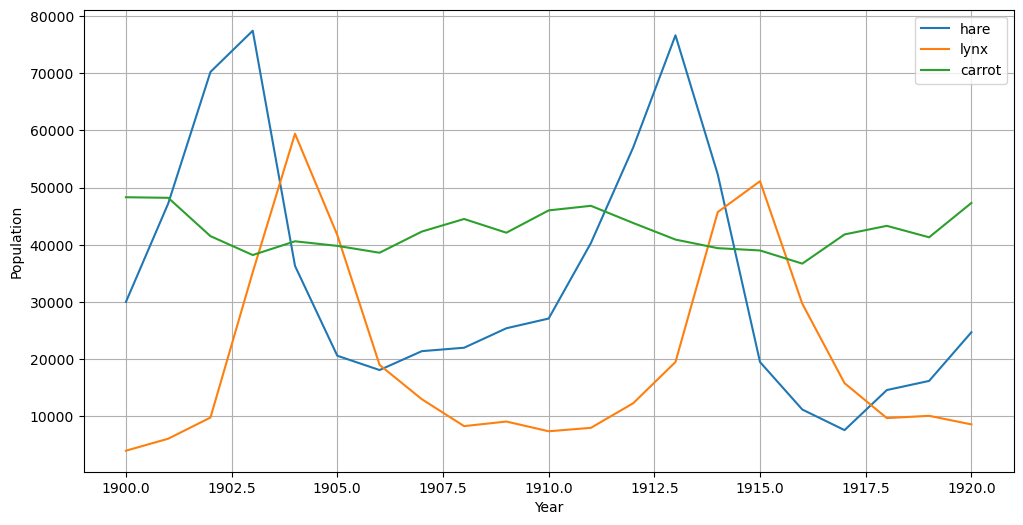

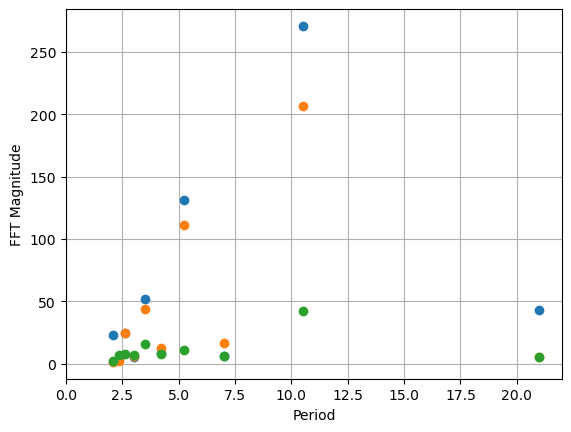

There is probably a period of around  10.5  years


In [4]:
from scipy import fftpack
filepath = "./data/populations.txt"
data = np.genfromtxt(filepath)
years = data[:, 0]
pop = data[:, 1:]

plt.figure(figsize=(12, 6))
plt.grid('on')
plt.plot(years, pop)
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(['hare', 'lynx', 'carrot'], loc=1)
plt.show()



ft_pop = fftpack.fft(pop, axis=0)
freq = fftpack.fftfreq(pop.shape[0], years[1] - years[0])
periods = 1 / freq[1:]

plt.figure()
plt.plot(periods, abs(ft_pop[1:,:]) * 1e-3, 'o')
plt.xlim(0, 22)
plt.xlabel('Period')
plt.ylabel('FFT Magnitude')
plt.grid('on')

plt.show()

index = np.argmax(abs(ft_pop[1:,0]))

print('There is probably a period of around ', periods[index], ' years')

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

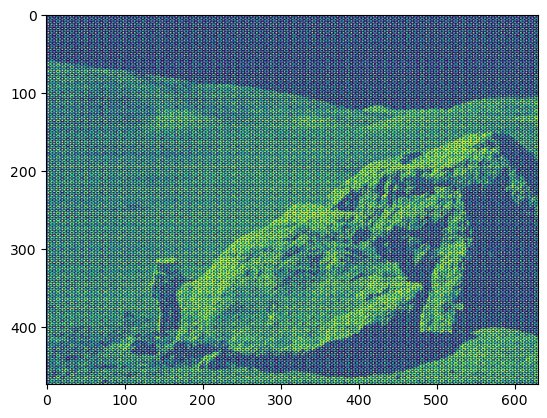

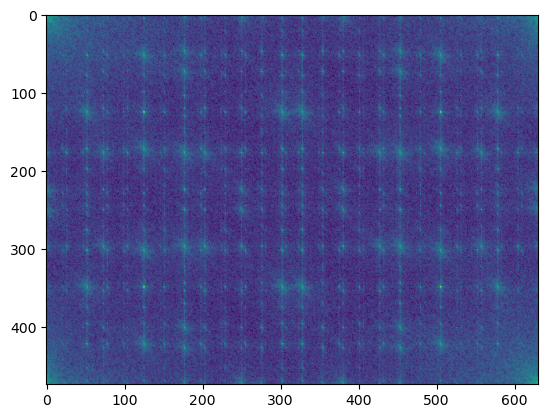

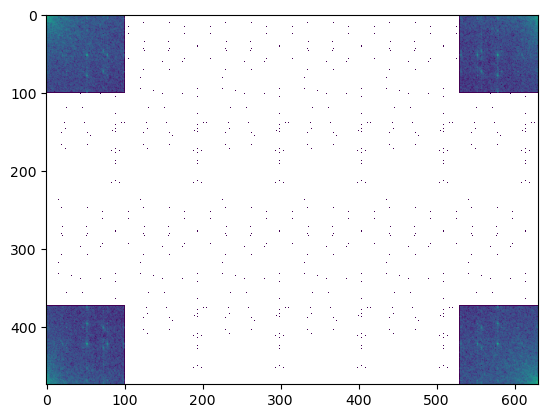

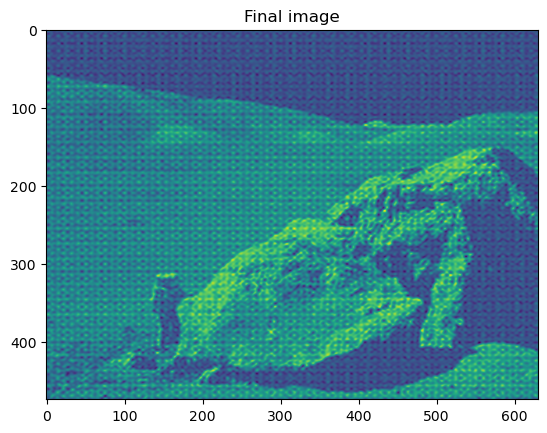

In [11]:
moon = plt.imread("images/moonlanding.png")
plt.imshow(moon)
plt.show()

fft = fftpack.fft2(moon)
plt.imshow(abs(fft), norm=LogNorm(vmin=5))
plt.show()


weight, height = moon_fft.shape
corner_size=100

fft[corner_size:weight-corner_size, :] = 0  
fft[:, corner_size:height-corner_size] = 0  

plt.imshow(abs(fft), norm=LogNorm(vmin=5))
plt.show()

image = fftpack.ifft2(fft).real

plt.figure()
plt.imshow(image)
plt.title('Final image')
plt.show()